In [2]:
import pandas as pd
import deepl
import numpy as np 
import re
from transformers import pipeline
import os
from dotenv import load_dotenv
load_dotenv() 

# declear API keys
DEEPL_API_KEY = os.getenv("DEEPL_API_KEY")
AIRTABLE_API_KEY = os.getenv("AIRTABLE_API_KEY")
AIRTABLE_BASE_ID_UKR = os.getenv("AIRTABLE_BASE_ID_UKR")





# TODO proper text cleaning 
# TODO cost calculation for whole df 
# TODO does lambda save results if limit hit
# TODO filter for websites, adresses, 
# TODO how can NLP be used within Government Crisis, think of RQ ?


# Exploratory Analysis

In [8]:
df = pd.read_csv('../data/telegramAllGroups.csv')
df['messageText'] = df['messageText'].str.replace(u'\n', '')
print(df.shape)
df.replace('...', np.nan, inplace=True) 
df.dropna(subset=['messageSender', 'messageText'],inplace=True) #what does it mean if messageSender empty
df.messageSender = df.messageSender.astype(int)
print(df.shape)
# df.drop_duplicates(keep='first',inplace=True)
# print(df.shape)
df.drop_duplicates(subset=['messageText', 'messageSender', 'messageDatetime'], keep='first',inplace=True)
print(df.shape)

dfZ = df.loc[df['messageText'].str.contains("Цюрих|Zurich|Zürich", case=False)] # TODO better filter for Zurich postcodes, probably just minor
# df = df[df.chat=="https://t.me/refugeesinSwitzerland"]
# dfZ = dfZ[dfZ.chat=="https://t.me/refugeesinSwitzerland"]
df['messageText'].to_csv("../data/BERTopicInput.csv", header=False, index=None)

(366015, 4)
(312533, 4)
(297180, 4)


In [6]:
df.messageText[47]

'Здравствуйте, подскажите пожалуйста, если человек выехал из Украины до 24 февраля не в страну ЕС, и после того как началась война въехал в шенгенскую зону из этой страны, мне дадут временную защиту или могут отказать?'

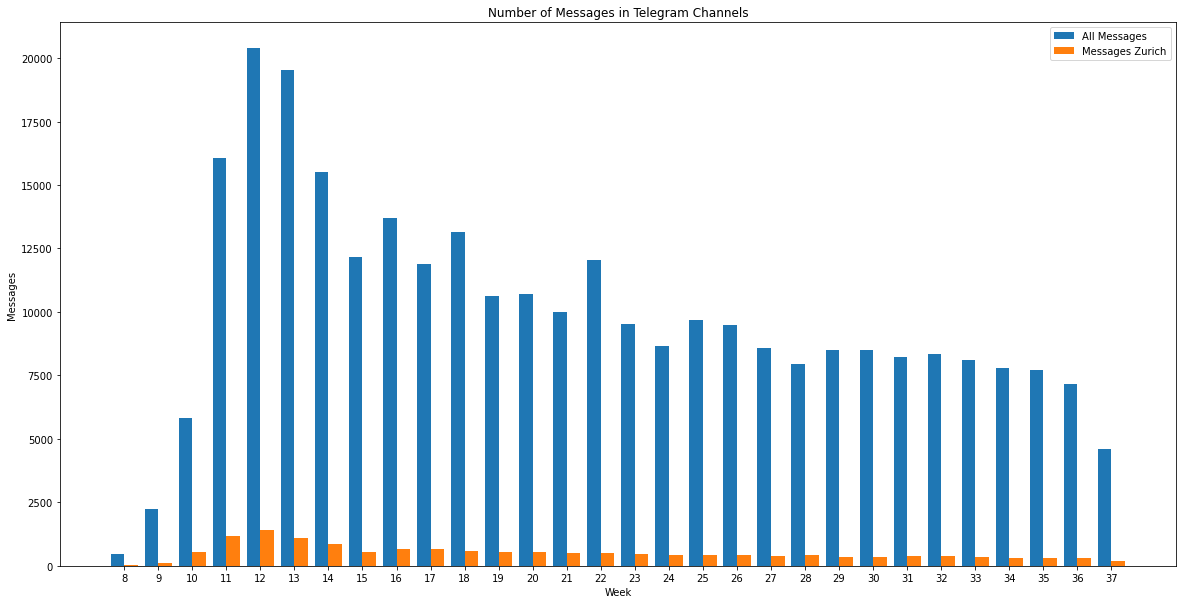

In [7]:
import matplotlib.pyplot as plt 

dfWeek = pd.DataFrame(df['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1]).value_counts()).merge(dfZ['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1]).value_counts(), left_index=True, right_index=True).sort_index()

X = dfWeek.index
nrMessagesPerWeekAll = dfWeek.messageDatetime_x
nrMessagesPerWeekZurich = dfWeek.messageDatetime_y
  
X_axis = np.arange(len(X))
plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, nrMessagesPerWeekAll, 0.4, label = 'All Messages')
plt.bar(X_axis + 0.2, nrMessagesPerWeekZurich, 0.4, label = 'Messages Zurich')
  
plt.xticks(X_axis, X)
plt.xlabel("Week")
plt.ylabel("Messages")
plt.title("Number of Messages in Telegram Channels")
plt.legend()
# plt.savefig('../plots/allTelegramGroups.jpg')
# plt.show()

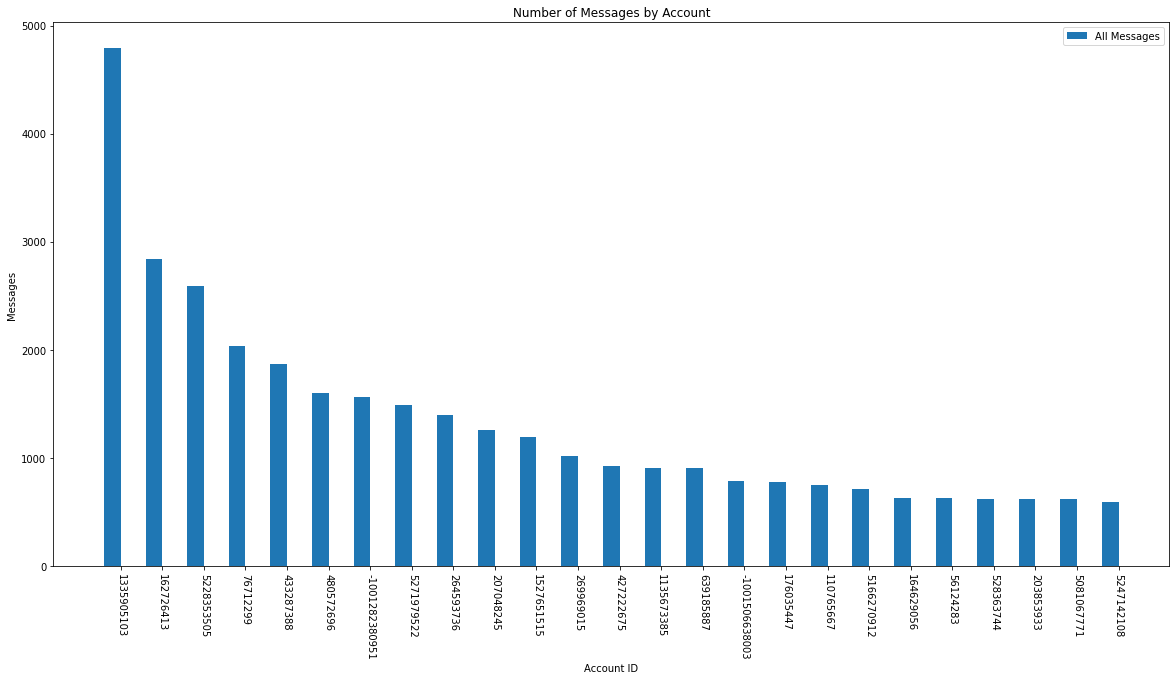

In [25]:
# dfWeek = pd.DataFrame(df['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1]).value_counts()).merge(dfZ['messageDatetime'].apply(lambda x: pd.to_datetime(x).isocalendar()[1]).value_counts(), left_index=True, right_index=True).sort_index()

X = df.messageSender.value_counts()[:25].index
nrMessagesPerWeekAll = df.messageSender.value_counts()[:25]
# nrMessagesPerWeekZurich = dfWeek.messageDatetime_y
  
X_axis = np.arange(len(X))

plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, nrMessagesPerWeekAll, 0.4, label = 'All Messages')
# plt.bar(X_axis + 0.2, nrMessagesPerWeekZurich, 0.4, label = 'Messages Zurich')
  
plt.xticks(X_axis, X, rotation=-90)
plt.xlabel("Account ID")
plt.ylabel("Messages")
plt.title("Number of Messages by Account")
plt.legend()
# plt.savefig('../plots/allTelegramGroupsMostMessagesBySingleAccountTop25.jpg')

In [15]:
# df.messageSender.value_counts().reset_index()[:1000].to_csv('../data/results/1000MostActiveUsers.csv', index=None, header=['sender_id', 'messages_send'] )
df.messageSender.value_counts()[:1000]

1335905103    18555
5228353505    11024
433287388      9402
162726413      8203
76712299       5651
              ...  
1527691472      125
474387451       125
5123333651      125
1016921692      125
793788239       125
Name: messageSender, Length: 1000, dtype: int64

In [16]:
df[df.messageSender==1335905103].messageText[1]

'Я не знаю в каком вы кантоне и какие у вас порядки. Вы лист с разбивкой полученной помощи видели? У многих вроде там есть строчка транспорт. Но не уверена. Уверена, что кантон Во выдает проездной на те зоны, которые человек пересекает по дороге в соцслужбу. Например, человек живет в Гланд. Значит наверняка у него будет зона и Ролля и Моржа, тк он их проезжает по дороге в Лозанну.'

In [17]:
from collections import Counter
from urllib.parse import urlparse

baselevel=3

def retrieve_base_url(url, baselevel=0):
    if baselevel==0:
        try:
            parseresult = urlparse(url)
            url_clean = parseresult.scheme + '//' + parseresult.netloc
            return url_clean
        except:
            ValueError
    if baselevel>=1:
        try:
            parseresult = urlparse(url)
            url_clean = parseresult.scheme + '//' + parseresult.netloc + '/' + '/'.join(parseresult.path.split('/')[1:baselevel+1])
            print(url_clean)
            return url_clean
        except:
            ValueError



df['messageURL'] = df['messageText'].apply(lambda x: re.findall(r'(https?://[^\s]+)', x))
urlList = [x for xs in df['messageURL'] for x in xs]
# pd.Series(urlList).value_counts().to_csv("../data/results/mostSharedLinks.csv")
urlTelegramList = [url for url in urlList if url.startswith("https://t.me")]
# pd.Series(urlTelegramList).value_counts().to_csv("../data/results/mostSharedLinksTelegramGroups.csv")
urlBaseLevelList = [retrieve_base_url(url=url,baselevel=baselevel) for url in urlList]
# pd.Series(urlBaseLevelList).value_counts().to_csv(f"../data/results/mostSharedBaseLevel{baselevel}Links.csv")


https//magellanbus.com.ua2)/
https//instagram.com/esco.express
https//www.facebook.com/groups/1145285448894679/
https//t.me/refugeesinSwitzerland/115833
https//www.admin.ch/gov/de/start
https//www.facebook.com/profile.php
https//magellanbus.com.uaFlixbus.com/
https//t.me/refugeesinSwitzerland/113441
https//vuso.ua/hubkaizen.com
https//magellanbus.com.ua2)/
https//instagram.com/esco.express
https//www.facebook.com/groups/1145285448894679/
https//www.bazg.admin.ch/dam/bazg/de
https//www.sunrise.ch/content/sunrise/de
https//www.sunrise.ch/content/sunrise/de
https//www.blv.admin.ch/blv/en/home
https//vuso.ua/**).
https//vuso.ua/uslugi/turisticheskoe-strahovanie.html
https//vuso.ua/uslugi/zelenaya-karta.html
https//hubkaizen-greencard.ewa.ua/✈️
https//hubkaizen-travel.ewa.ua/🚔
https//hubkaizen-insurance.ewa.ua/🚗Замовити
https//hubkaizen.com/
https//www.grandfrais.com/magasins/ferney-voltaire
https//www.blv.admin.ch/blv/en/home
https//posts.naym.me/3OqgEGd)
https//posts.naym.me/3OqgEGd)
http

In [18]:
pd.Series(urlTelegramList).value_counts().to_csv("../data/value_counts_telegramchannels.csv")

# Bag of Words & TF-IDF

In [52]:
#define stopwords
from nltk.corpus import stopwords
stopWords = stopwords.words('english') 
for word in stopwords.words('german'):
    stopWords.append(stopwords)
for word in stopwords.words('russian'):
    stopWords.append(word)
ukrstopWords = ['а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї', 'абичиїй', 'абичиїм', 'абичиїми', 'абичиїх', 'абичого', 'абичому', 'абищо', 'абияка', 'абияке', 'абиякий', 'абияким', 'абиякими', 'абияких', 'абиякого', 'абиякому', 'абиякою', 'абиякої', 'абияку', 'абиякі', 'абиякій', 'абиякім', 'або', 'абощо', 'авжеж', 'авось', 'ага', 'ад', 'адже', 'аж', 'ажень', 'аз', 'ай', 'але', 'ало', 'амінь', 'ант', 'ану', 'ані', 'аніде', 'аніж', 'анізащо', 'аніким', 'анікого', 'анікогісінько', 'аніколи', 'анікому', 'аніскільки', 'аніхто', 'анічим', 'анічого', 'анічогісінько', 'анічому', 'аніщо', 'аніяка', 'аніяке', 'аніякий', 'аніяким', 'аніякими', 'аніяких', 'аніякого', 'аніякому', 'аніякою', 'аніякої', 'аніяку', 'аніякі', 'аніякій', 'аніякім', 'аніякісенька', 'аніякісеньке', 'аніякісенький', 'аніякісеньким', 'аніякісенькими', 'аніякісеньких', 'аніякісенького', 'аніякісенькому', 'аніякісенькою', 'аніякісенької', 'аніякісеньку', 'аніякісенькі', 'аніякісенькій', 'аніякісенькім', 'аніякісінька', 'аніякісіньке', 'аніякісінький', 'аніякісіньким', 'аніякісінькими', 'аніякісіньких', 'аніякісінького', 'аніякісінькому', 'аніякісінькою', 'аніякісінької', 'аніякісіньку', 'аніякісінькі', 'аніякісінькій', 'аніякісінькім', 'ат', 'ато', 'атож', 'ау', 'ах', 'ач', 'ачей', 'аякже', 'б', 'ба', 'багато', 'багатьма', 'багатьом', 'багатьох', 'баз', 'бай', 'бат', 'бах', 'бац', 'баш', 'бе', 'беж', 'без', 'безперервно', 'бел', 'бер', 'би', 'бир', 'бич', 'близько', 'близько від', 'бо', 'бов', 'бод', 'бодай', 'боз', 'бош', 'був', 'буває', 'буде', 'будем', 'будемо', 'будете', 'будеш', 'буду', 'будуть', 'будь', 'будь ласка', 'будьмо', 'будьте', 'була', 'були', 'було', 'бути', 'бух', 'буц', 'буцім', 'буцімто', 'бі', 'біб', 'більш', 'більше', 'біля', 'в', 'в бік', 'в залежності від', 'в міру', 'в напрямі до', 'в порівнянні з', 'в процесі', 'в результаті', 'в ролі', 'в силу', 'в сторону', 'в супроводі', 'в ході', "в ім'я", 'в інтересах', 'вад', 'важлива', 'важливе', 'важливий', 'важливі', 'вак', 'вам', 'вами', 'ван', 'вас', 'ват', 'ваш', 'ваша', 'ваше', 'вашим', 'вашими', 'ваших', 'вашого', 'вашому', 'вашою', 'вашої', 'вашу', 'ваші', 'вашій', 'вашім', 'ввесь', 'вві', 'вгору', 'вдалині', 'вед', 'верх', 'весь', 'вех', 'вже', 'вздовж', 'ви', 'виз', 'вис', 'височині', 'вище ', 'вйо', 'власне', 'властиво', 'вміти', 'внаслідок', 'вниз', 'внизу', 'во', 'вон', 'вона', 'вони', 'воно', 'восьмий', 'вперед', 'вподовж', 'впоперек', 'впритиск', 'впритул', 'впродовж', 'впрост', 'все', 'всередині', 'всею', 'вслід', 'всупереч', 'всього', 'всьому', 'всю', 'всюди', 'вся', 'всяк', 'всяка', 'всяке', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякому', 'всякою', 'всякої', 'всяку', 'всякі', 'всякій', 'всякім', 'всі', 'всій', 'всіляка', 'всіляке', 'всілякий', 'всіляким', 'всілякими', 'всіляких', 'всілякого', 'всілякому', 'всілякою', 'всілякої', 'всіляку', 'всілякі', 'всілякій', 'всілякім', 'всім', 'всіма', 'всіх', 'всією', 'всієї', 'втім', 'ві', 'віг', 'від', 'від імені', 'віддалік від', 'відколи', 'відносно', 'відповідно', 'відповідно до', 'відсотків', 'відтепер', 'відтоді', 'він', 'вісім', 'вісімнадцятий', 'вісімнадцять', 'віт', 'віф', 'віх', 'віц', 'віщо', 'віщось', 'г', 'га', 'гав', 'гаразд', 'ге', 'гез', 'гем', 'геп', 'гет', 'геть', 'гех', 'ги', 'гик', 'гир', 'гич', 'гм', 'го', 'говорив', 'гог', 'гоп', 'гоц', 'гу', 'гуп', 'д', 'да', 'давай', 'давати', 'давно', 'далеко', 'далеко від', 'далі', 'даром', 'два', 'двадцятий', 'двадцять', 'дванадцятий', 'дванадцять', 'двох', 'дві', 'де', "дев'ятий", "дев'ятнадцятий", "дев'ятнадцять", "дев'ять", 'дедалі', 'деким', 'декого', 'деколи', 'декому', 'декотра', 'декотре', 'декотрий', 'декотрим', 'декотрими', 'декотрих', 'декотрого', 'декотрому', 'декотрою', 'декотрої', 'декотру', 'декотрі', 'декотрій', 'декотрім', 'декілька', 'декільком', 'декількома', 'декількох', 'декім', 'десь', 'десятий', 'десять', 'дехто', 'дечий', 'дечийого', 'дечийому', 'дечим', 'дечию', 'дечия', 'дечиє', 'дечиєму', 'дечиєю', 'дечиєї', 'дечиї', 'дечиїй', 'дечиїм', 'дечиїми', 'дечиїх', 'дечого', 'дечому', 'дечім', 'дещо', 'деяка', 'деяке', 'деякий', 'деяким', 'деякими', 'деяких', 'деякого', 'деякому', 'деякою', 'деякої', 'деяку', 'деякі', 'деякій', 'деякім', 'деінде', 'для', 'до', 'добре', 'довго', 'довкола', 'довкіл', 'дог', 'доки', 'допоки', 'допіру', 'досить', 'досі', 'дотепер', 'доти', 'другий', 'друго', 'дуже', 'дякую', 'дійсно', 'діл', 'е', 'еге', 'еж', 'ей', 'ерг', 'ест', 'ет', 'ех', 'еч', 'ж', 'же', 'жоден', 'жодна', 'жодне', 'жодний', 'жодним', 'жодними', 'жодних', 'жодного', 'жодному', 'жодною', 'жодної', 'жодну', 'жодні', 'жодній', 'жоднім', 'жоднісінька', 'жоднісіньке', 'жоднісінький', 'жоднісіньким', 'жоднісінькими', 'жоднісіньких', 'жоднісінького', 'жоднісінькому', 'жоднісінькою', 'жоднісінької', 'жоднісіньку', 'жоднісінькі', 'жоднісінькій', 'жоднісінькім', 'жуз', 'з', 'з метою', 'з нагоди', 'з приводу', 'з розрахунку на', 'з-за', 'з-над', 'з-перед', 'з-поза', 'з-поміж', 'з-понад', 'з-поперед', 'з-посеред', 'з-проміж', 'з-під', 'з-серед', 'за', 'за винятком', 'за допомогою', 'за посередництвом', 'за рахунок', 'завгодно', 'завдяки', 'завжди', 'завше', 'задля', 'зазвичай', 'зайнята', 'зайнятий', 'зайнято', 'зайняті', 'залежно', 'залежно від', 'замість', 'занадто', 'заради', 'зараз', 'зас', 'зате', 'збоку', 'збоку від', 'зважаючи на', 'зверх ', 'зверху', 'звичайно', 'звиш', 'звідки', 'звідкилясь', 'звідкись', 'звідкіль', 'звідкіля', 'звідкілясь', 'звідси', 'звідсіль', 'звідсіля', 'звідти', 'звідтіль', 'звідтіля', 'звідусюди', 'звідусіль', 'звідціля', 'згідно з', 'здається', 'здовж', 'зем', 'зет', 'ззаду', 'зиз', 'зик', 'значить', 'знову', 'зо', 'зовсім', 'зсередини', 'зух', 'зі', 'зіс', 'и', 'ич', 'й', 'ймовірно', 'йно', 'йо', 'його', 'йой', 'йол', 'йому', 'йор', 'йот', 'йох', 'к', 'каже', 'каз', 'кар', 'каф', 'ках', 'ке', 'кед', 'кет', 'кеш', 'кив', 'кий', 'кил', 'ким', 'кимось', 'кимсь', 'ких', 'киш', 'коб', 'коби', 'кого', 'когось', 'кожен', 'кожна', 'кожне', 'кожний', 'кожним', 'кожними', 'кожних', 'кожного', 'кожному', 'кожною', 'кожної', 'кожну', 'кожні', 'кожній', 'кожнім', 'кожнісінька', 'кожнісіньке', 'кожнісінький', 'кожнісіньким', 'кожнісінькими', 'кожнісіньких', 'кожнісінького', 'кожнісінькому', 'кожнісінькою', 'кожнісінької', 'кожнісіньку', 'кожнісінькі', 'кожнісінькій', 'кожнісінькім', 'коли', 'колись', 'коло', 'кому', 'комусь', 'котра', 'котрась', 'котре', 'котресь', 'котрий', 'котрийсь', 'котрим', 'котрими', 'котримись', 'котримось', 'котримсь', 'котрих', 'котрихось', 'котрихсь', 'котрого', 'котрогось', 'котрому', 'котромусь', 'котрою', 'котроюсь', 'котрої', 'котроїсь', 'котру', 'котрусь', 'котрі', 'котрій', 'котрійсь', 'котрім', 'котрімсь', 'котрісь', 'коц', 'коч', 'коштом', 'край', 'краще', 'кру', 'круг', 'кругом', 'крю', 'кря', 'крізь', 'крім', 'куди', 'кудись', 'кудою', 'кілька', 'кільком', 'кількома', 'кількох', 'кім', 'кімось', 'кімсь', 'кінець', 'л', 'лаж', 'лап', 'лас', 'лат', 'ле', 'ледве', 'ледь', 'лет', 'лиш', 'лише', 'лишень', 'лум', 'луп', 'лут', 'льє', 'люди', 'людина', 'ля', 'лі', 'ліворуч від', 'лік', 'лім', 'м', 'мабуть', 'майже', 'мало', 'мати', 'мац', 'ме', 'меж', 'мене', 'менше', 'мені', 'мерсі', 'мет', 'мжа', 'ми', 'мимо ', 'миру', 'мит', 'мною', 'мо', 'мов', 'мовби', 'мовбито', 'могла', 'могли', 'могло', 'мого', 'могти', 'мож', 'може', 'можем', 'можемо', 'можете', 'можеш', 'можна', 'можу', 'можуть', 'можіть', 'мой', 'мол', 'мою', 'моя', 'моє', 'моєму', 'моєю', 'моєї', 'мої', 'моїй', 'моїм', 'моїми', 'моїх', 'му', 'мі', 'міг', 'між', 'мій', 'мільйонів', 'н', 'на', 'на адресу', 'на базі', 'на благо', 'на випадок', 'на відміну від', 'на засадах', 'на знак', 'на зразок', 'на користь', 'на кшталт', 'на межі', 'на основі', 'на противагу', 'на підставі', 'на честь', 'на чолі', 'на ґрунті', 'навколо', 'навкруг', 'навкруги ', 'навкіл', 'навпаки', 'навперейми', 'навпроти', 'навіть', 'навіщо', 'навіщось', 'нагорі', 'над', 'надо', 'надовкола', 'надокола', 'наді', 'назавжди', 'назад', 'назустріч', 'най', 'найбільш', 'нам', 'нами', 'наоколо ', 'наокруг ', 'наокруги ', 'наокіл', 'наперед', 'напередодні', 'напереді', 'наперекір', 'напереріз', 'наприкінці', 'напроти', 'нарешті', 'нарівні з', 'нас', 'насеред', 'насподі', 'наспід', 'настрічу', 'насупроти', 'насупротив ', 'нате', 'наче', 'начеб', 'начебто', 'наш', 'наша', 'наше', 'нашим', 'нашими', 'наших', 'нашого', 'нашому', 'нашою', 'нашої', 'нашу', 'наші', 'нашій', 'нашім', 'не', 'не до', 'не можна', 'неабичим', 'неабичого', 'неабичому', 'неабищо', 'небагато', 'небагатьма', 'небагатьом', 'небагатьох', 'небудь', 'невважаючи', 'невже', 'недалеко', 'недалеко від', 'неж', 'незалежно від', 'незважаючи', 'незважаючи на', 'ней', 'немає', 'немов', 'немовби', 'немовбито', 'неначе', 'неначебто', 'неподалеку', 'неподалеку від', 'неподалечку', 'неподалечку від', 'неподалік', 'неподалік від', 'нерідко', 'нех', 'нехай', 'нещодавно', 'нею', 'неї', 'нижче', 'низько', 'ник', 'ним', 'ними', 'них', 'нич', 'но', 'ну', 'нуг', 'нуд', 'нум', 'нумо', 'нумте', 'ньо', 'нього', 'ньому', 'ню', 'нюх', 'ня', 'няв', 'ні', 'ніби', 'ніби-то', 'нібито', 'ніде', 'ніж', 'нізащо', 'нізвідки', 'нізвідкіля', 'ній', 'ніким', 'нікого', 'нікогісінько', 'ніколи', 'нікому', 'нікотра', 'нікотре', 'нікотрий', 'нікотрим', 'нікотрими', 'нікотрих', 'нікотрого', 'нікотрому', 'нікотрою', 'нікотрої', 'нікотру', 'нікотрі', 'нікотрій', 'нікотрім', 'нікуди', 'нім', 'нінащо', 'ніскільки', 'ніт', 'ніхто', 'нічий', 'нічийна', 'нічийне', 'нічийний', 'нічийним', 'нічийними', 'нічийних', 'нічийного', 'нічийному', 'нічийною', 'нічийної', 'нічийну', 'нічийні', 'нічийній', 'нічийнім', 'нічийого', 'нічийому', 'нічим', 'нічию', 'нічия', 'нічиє', 'нічиєму', 'нічиєю', 'нічиєї', 'нічиї', 'нічиїй', 'нічиїм', 'нічиїми', 'нічиїх', 'нічого', 'нічому', 'ніщо', 'ніяк', 'ніяка', 'ніяке', 'ніякий', 'ніяким', 'ніякими', 'ніяких', 'ніякого', 'ніякому', 'ніякою', 'ніякої', 'ніяку', 'ніякі', 'ніякій', 'ніякім', 'ніякісінька', 'ніякісіньке', 'ніякісінький', 'ніякісіньким', 'ніякісінькими', 'ніякісіньких', 'ніякісінького', 'ніякісінькому', 'ніякісінькою', 'ніякісінької', 'ніякісіньку', 'ніякісінькі', 'ніякісінькій', 'ніякісінькім', 'о', 'об', 'обабіч', 'обаполи', 'обидва', 'обр', 'обік', 'обіруч', 'обіч', 'ов', 'од', 'один', 'одинадцятий', 'одинадцять', 'одна', 'однак', 'одначе', 'одне', 'одним', 'одними', 'одних', 'одно', 'одного', 'одного разу', 'одному', 'одною', 'одної', 'одну', 'одні', 'одній', 'однім', 'однією', 'однієї', 'ож', 'ой', 'окрай', 'окроме', 'округ', 'округи', 'окрім', 'окіл', 'ом', 'он', 'онде', 'онно', 'оно', 'оподаль', 'оподаль від', 'оподалік', 'оподалік від', 'опостін', 'опостінь', 'опроче', 'опріч', 'опріче', 'опісля', 'осе', 'оскільки', 'особливо', 'осторонь', 'ось', 'осісьо', 'от', 'ота', 'отак', 'отака', 'отаке', 'отакий', 'отаким', 'отакими', 'отаких', 'отакого', 'отакому', 'отакою', 'отакої', 'отаку', 'отакі', 'отакій', 'отакім', 'отакісінька', 'отакісіньке', 'отакісінький', 'отакісіньким', 'отакісінькими', 'отакісіньких', 'отакісінького', 'отакісінькому', 'отакісінькою', 'отакісінької', 'отакісіньку', 'отакісінькі', 'отакісінькій', 'отакісінькім', 'отам', 'оте', 'отже', 'отим', 'отими', 'отих', 'ото', 'отого', 'отож', 'отой', 'отому', 'отою', 'отої', 'отсе', 'оттак', 'отто', 'оту', 'отут', 'оті', 'отій', 'отім', 'отією', 'отієї', 'ох', 'оце', 'оцей', 'оцим', 'оцими', 'оцих', 'оцього', 'оцьому', 'оцю', 'оця', 'оці', 'оцій', 'оцім', 'оцією', 'оцієї', 'п', "п'я", "п'ятий", "п'ятнадцятий", "п'ятнадцять", "п'ять", 'па', 'пад', 'пак', 'пек', 'перед', 'передо', 'переді', 'перетака', 'перетаке', 'перетакий', 'перетаким', 'перетакими', 'перетаких', 'перетакого', 'перетакому', 'перетакою', 'перетакої', 'перетаку', 'перетакі', 'перетакій', 'перетакім', 'перший', 'пиж', 'плі', 'по', 'поблизу', 'побік', 'побіля', 'побіч', 'поверх', 'повз', 'повздовж', 'повинно', 'повище', 'повсюди', 'повсюдно', 'подаль від', 'подалі від', 'подекуди', 'подеяка', 'подеяке', 'подеякий', 'подеяким', 'подеякими', 'подеяких', 'подеякого', 'подеякому', 'подеякою', 'подеякої', 'подеяку', 'подеякі', 'подеякій', 'подеякім', 'подовж', 'подібно до', 'поз', 'поза', 'позад', 'позаду', 'позата', 'позате', 'позатим', 'позатими', 'позатих', 'позатого', 'позатой', 'позатому', 'позатою', 'позатої', 'позату', 'позаті', 'позатій', 'позатім', 'позатією', 'позатієї', 'позаяк', 'поздовж', 'поки', 'покрай', 'покіль', 'помежи', 'помимо', 'поміж', 'помість', 'понад', 'понадо', 'понаді', 'понижче', 'пообіч', 'поодаль від', 'поодалік від', 'поперед', 'попереду', 'поперек', 'попліч', 'попри', 'попросту', 'попід', 'пора', 'поруч', 'поряд', 'поряд з', 'порівняно з', 'посеред', 'посередині', 'потрібно', 'потім', 'поуз', 'початку', 'почерез', 'праворуч від', 'пред', 'предо', 'преді', 'прекрасно', 'прецінь', 'при', 'притому', 'причому', 'причім', 'про', 'проз', 'промеж', 'проміж', 'просто', 'проте', 'проти', 'против', 'противно', 'протягом', 'пря', 'пріч', 'пхе', 'пху', 'пі', 'пів', 'півперек', 'під', 'під знаком', 'під приводом', 'під час', 'підо', 'пізніше', 'пім', 'пір', 'після', 'р', 'ради', 'раз', 'разом з', 'разу', 'рано', 'раніш', 'раніш від', 'раніше', 'раніше від', 'раптом', 'ре', 'рет', 'риж', 'рим', 'рип', 'роб', 'року', 'років', 'рос', 'рох', 'році', 'рус', 'рух', 'руч', 'рік', 'с', 'саж', 'саз', 'сак', 'сам', 'сама', 'саме', 'сами', 'самий', 'самим', 'самими', 'самих', 'само', 'самого', 'самому', 'самою', 'самої', 'саму', 'самі', 'самій', 'самім', 'сап', 'сас', 'свого', 'свою', 'своя', 'своє', 'своєму', 'своєю', 'своєї', 'свої', 'своїй', 'своїм', 'своїми', 'своїх', 'свій', 'се', 'себе', 'себто', 'сей', 'сен', 'серед', 'середи', 'середу', 'сеч', 'си', 'сив', 'сиг', 'сиз', 'сик', 'сиріч', 'сих', 'сказав', 'сказала', 'сказати', 'скрізь', 'скільки', 'скільки-то', 'скількись', 'скільком', 'скількома', 'скількомась', 'скількомось', 'скількомсь', 'скількох', 'скількохось', 'скількохсь', 'сли', 'слідом за', 'соб', 'собою', 'собі', 'соп', 'спасибі', 'спереду', 'спочатку', 'справ', 'справді', 'став', 'стосовно', 'стільки', 'стільком', 'стількома', 'стількох', 'су', 'судячи з', 'супроти', 'супротив', 'суть', 'суч', 'суш', 'сьогодні', 'сьомий', 'сюди', 'ся', 'сяг', 'сяк', 'сяка', 'сяке', 'сякий', 'сяким', 'сякими', 'сяких', 'сякого', 'сякому', 'сякою', 'сякої', 'сяку', 'сякі', 'сякій', 'сякім', 'сям', 'сі', 'сім', 'сімнадцятий', 'сімнадцять', 'сіп', 'т', 'та', 'таж', 'так', 'така', 'таке', 'такенна', 'такенне', 'такенний', 'такенним', 'такенними', 'такенних', 'такенного', 'такенному', 'такенною', 'такенної', 'такенну', 'такенні', 'такенній', 'такеннім', 'таки', 'такий', 'таким', 'такими', 'таких', 'такого', 'також', 'такому', 'такою', 'такої', 'таку', 'такі', 'такій', 'такім', 'такісінька', 'такісіньке', 'такісінький', 'такісіньким', 'такісінькими', 'такісіньких', 'такісінького', 'такісінькому', 'такісінькою', 'такісінької', 'такісіньку', 'такісінькі', 'такісінькій', 'такісінькім', 'тал', 'там', 'тамки', 'тамта', 'тамте', 'тамтим', 'тамтими', 'тамтих', 'тамтого', 'тамтой', 'тамтому', 'тамтою', 'тамтої', 'тамту', 'тамті', 'тамтій', 'тамтім', 'тамтією', 'тамтієї', 'тар', 'тат', 'таш', 'тва', 'твого', 'твою', 'твоя', 'твоє', 'твоєму', 'твоєю', 'твоєї', 'твої', 'твоїй', 'твоїм', 'твоїми', 'твоїх', 'твій', 'те', 'тебе', 'тег', 'теж', 'тем', 'тепер', 'теперечки', 'тес', 'теф', 'теє', 'ти', 'тик', 'тил', 'тим', 'тими', 'тисяч', 'тих', 'то', 'тобою', 'тобто', 'тобі', 'того', 'тоді', 'тож', 'той', 'тол', 'тому', 'тому що', 'тот', 'тощо', 'тою', 'тої', 'тра', 'тре', 'треба', 'третій', 'три', 'тринадцятий', 'тринадцять', 'трохи', 'тс', 'тсс', 'ту', 'туди', 'тудою', 'туп', 'тут', 'тутеньки', 'тутечки', 'тутки', 'туф', 'туц', 'тю', 'тюг', 'тюп', 'тяг', 'тяж', 'тям', 'тяп', 'ті', 'тій', 'тільки', 'тім', 'тією', 'у', 'у бік', 'у вигляді', 'у випадку', 'у відповідності до', 'у відповідь на', 'у залежності від', "у зв'язку з", 'у міру', 'у напрямі до', 'у порівнянні з', 'у процесі', 'у результаті', 'у ролі', 'у силу', 'у сторону', 'у супроводі', 'у ході', 'ув', 'увесь', 'уві', 'угу', 'уже', 'узбіч', 'уздовж', 'укр', 'ум', 'унаслідок', 'униз', 'унизу', 'унт', 'уперед', 'уподовж', 'упоперек', 'упритиск до', 'упритул до', 'упродовж', 'упрост', 'ус', 'усе', 'усередині', 'услід', 'услід за', 'усупереч', 'усього', 'усьому', 'усю', 'усюди', 'уся', 'усяк', 'усяка', 'усяке', 'усякий', 'усяким', 'усякими', 'усяких', 'усякого', 'усякому', 'усякою', 'усякої', 'усяку', 'усякі', 'усякій', 'усякім', 'усі', 'усій', 'усіляка', 'усіляке', 'усілякий', 'усіляким', 'усілякими', 'усіляких', 'усілякого', 'усілякому', 'усілякою', 'усілякої', 'усіляку', 'усілякі', 'усілякій', 'усілякім', 'усім', 'усіма', 'усіх', 'усією', 'усієї', 'утім', 'ух', 'ф', "ф'ю", 'фа', 'фаг', 'фай', 'фат', 'фе', 'фед', 'фез', 'фес', 'фет', 'фзн', 'фоб', 'фот', 'фра', 'фру', 'фу', 'фук', 'фур', 'фус', 'фіш', 'х', 'ха', 'хаз', 'хай', 'хап', 'хат', 'хащ', 'хе', 'хет', 'хи', 'хиб', 'хм', 'хо', 'хов', 'хол', 'хон', 'хоп', 'хор', 'хотіти', 'хоч', 'хоча', 'хочеш', 'хро', 'хрю', 'хто', 'хтось', 'ху', 'хуз', 'хук', 'хух', 'хху', 'хіба', 'ц', 'це', 'цебто', 'цей', 'цеп', 'ци', 'цим', 'цими', 'цир', 'цих', 'цло', 'цоб', 'цок', 'цоп', 'цор', 'цс', 'цсс', 'цуг', 'цур', 'цуц', 'цього', 'цьому', 'цю', 'цюк', 'ця', 'цяв', 'цяп', 'ці', 'цід', 'цій', 'цім', 'ціною', 'цією', 'цієї', 'ч', 'чал', 'чар', 'час', 'часто', 'частіше', 'часу', 'чах', 'чей', 'чень', 'через', 'четвертий', 'чи', 'чий', 'чийого', 'чийогось', 'чийому', 'чийомусь', 'чийсь', 'чик', 'чим', 'чимось', 'чимсь', 'чир', 'численна', 'численне', 'численний', 'численним', 'численними', 'численних', 'численні', 'чию', 'чиюсь', 'чия', 'чиясь', 'чиє', 'чиєму', 'чиємусь', 'чиєсь', 'чиєю', 'чиєюсь', 'чиєї', 'чиєїсь', 'чиї', 'чиїй', 'чиїйсь', 'чиїм', 'чиїми', 'чиїмись', 'чиїмось', 'чиїмсь', 'чиїсь', 'чиїх', 'чиїхось', 'чиїхсь', 'чля', 'чого', 'чогось', 'чом', 'чому', 'чомусь', 'чон', 'чоп', 'чортзна', 'чос', 'чотири', 'чотирнадцятий', 'чотирнадцять', 'чу', 'чум', 'чур', 'чш', 'чім', 'чімось', 'чімсь', 'чіт', 'ш', 'ша', 'шаг', 'шал', 'шам', 'шво', 'шед', 'шен', 'шиз', 'шир', 'шляхом', 'шостий', 'шістнадцятий', 'шістнадцять', 'шість', 'щ', 'ще', 'щем', 'щеп', 'щип', 'щир', 'що', 'щоб', 'щоби', 'щодо', 'щойно', 'щоправда', 'щось', 'щі', 'ь', 'ю', 'юз', 'юн', 'юнь', 'юс', 'ют', 'юхт', 'я', 'яв', 'яд', 'яз', 'язь', 'як', 'яка', 'якась', 'якби', 'яке', 'якесь', 'який', 'якийсь', 'яким', 'якими', 'якимись', 'якимось', 'якимсь', 'яких', 'якихось', 'якихсь', 'якого', 'якогось', 'якому', 'якомусь', 'якось', 'якою', 'якоюсь', 'якої', 'якоїсь', 'якраз', 'яку', 'якусь', 'якщо', 'які', 'якій', 'якійсь', 'якім', 'якімсь', 'якісь', 'ял', 'ям', 'ян', 'янь', 'яо', 'яп', 'ярл', 'ясь', 'ять', 'є', 'єр', 'єси', 'і', 'ібн', 'ід', 'із', 'із-за', 'із-під', 'іззаду', 'ізм', 'ізсередини', 'ік', 'ікс', 'ікт', "ім'я", 'імовірно', 'інакша', 'інакше', 'інакший', 'інакшим', 'інакшими', 'інакших', 'інакшого', 'інакшому', 'інакшою', 'інакшої', 'інакшу', 'інакші', 'інакшій', 'інакшім', 'інколи', 'іноді', 'інша', 'інше', 'інший', 'іншим', 'іншими', 'інших', 'іншого', 'іншому', 'іншою', 'іншої', 'іншу', 'інші', 'іншій', 'іншім', 'інь', 'іч', 'іще', 'ї', 'їдь', 'їй', 'їм', 'їх', 'їхнього', 'їхньому', 'їхньою', 'їхньої', 'їхню', 'їхня', 'їхнє', 'їхні', 'їхній', 'їхнім', 'їхніми', 'їхніх', 'її', 'ґ']
# ukrainian stopwords as list below
for word in ukrstopWords:
    stopWords.append(word)


In [53]:
stopWords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df.messageText.to_list()
# corpus = ['Text processing is necessary.', 'Text processing is necessary and important.', 'Text processing is easy.']
vectorizer = CountVectorizer(stop_words=stopWords)
bow = vectorizer.fit_transform(corpus)
# print(vectorizer.get_feature_names())
# dfBOW= pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
sum_words = bow.sum(axis=0) 
word_freq = [(word, sum_words[0, idx]) for word, idx in  vectorizer.vocabulary_.items()]
word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)

In [55]:
# TODO why are all tf idf values 0
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stopWords)
vectorizer = TfidfVectorizer(stop_words=stopWords, max_features=1000)#, max_df=0.75, min_df=0)
# vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words=stopWords)
tfIdf = vectorizer.fit_transform(corpus)
dfTfIdf = pd.DataFrame(tfIdf[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
dfTfIdf = dfTfIdf.sort_values('TF-IDF', ascending=False)
# print(X.toarray())

/Users/kiliansprenkamp/miniforge3/envs/telegram/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [56]:
dfTfIdf

,TF-IDF
благодарю,0.725468
кантоне,0.688256
00,0.000000
получают,0.000000
получила,0.000000
...,...
живем,0.000000
живете,0.000000
животных,0.000000
живу,0.000000


# Hugging Face

In [ ]:
# rating 1-5 stars text classifier not trained for ukr or rus, but works fairly well
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [149]:
def sentiment_classifier(model, message):
    inputs = tokenizer(message, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    return logits
# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]

In [ ]:
dfT = dfT[dfT["messageText"].str.len()<512]
dfT['sentiment'] = dfT.messageText.apply(lambda x: sentiment_classifier(model, x))
dfT['star_rating'] = dfT.sentiment.apply(lambda x: model.config.id2label[x.argmax().item()][0])
# dfT.to_csv("../data/sentiment.csv", index=False)

In [35]:
dfT = pd.read_csv("../data/results/sentiment.csv")

In [64]:
mean_ratings_dict = {}
for i in df_stakeholder.type_code:
    mean_ratings_dict[i] =dfT[dfT['type_code'].str.contains(i, case=False)].star_rating.mean()

In [65]:
mean_ratings_dict

{'NP_ESSEN': 4.09375,
 'PC_Hotellerie': nan,
 'V_Helper': 3.012558869701727,
 'S_Social': 2.257425742574257,
 'S_Police': 2.2264150943396226,
 'S_Education': 4.0,
 'V_Host': 2.442528735632184,
 'RO_AOZ': 2.16600790513834,
 'NP_Shelters': 2.7476635514018692,
 'E_German': 3.2303030303030305,
 'NP_Campax': 2.566666666666667,
 'OP_Job': 3.0,
 'R_Refugees': nan,
 'NP_Donation': 2.8127659574468087,
 'PC_Shops': 2.76875,
 'OP_Accommodation': 4.0,
 'S_Communes': 2.413294797687861,
 'PC_Hotels': 2.5233644859813085,
 'S_Labor': 2.6296296296296298,
 'NP_SGG': 2.3333333333333335,
 'NP_SFL': 1.5,
 'S_Kanzlei': 2.617021276595745,
 'E_Kindergarten': 2.7555555555555555,
 'OP_MoneyCollect': 3.2905405405405403,
 'S_Veterinary': 3.015748031496063,
 'S_Health': nan,
 'S_Migration': 2.1272727272727274,
 'E_Schools': 2.844,
 'OP_Info': 4.0,
 'NP_WKP': nan,
 'RO_BAZ': 2.2661870503597124}

In [86]:
# misinformation, factual, other classifier Not very useful for us
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("saattrupdan/verdict-classifier")

model = AutoModelForSequenceClassification.from_pretrained("saattrupdan/verdict-classifier")

In [16]:
from transformers import MarianTokenizer, MarianMTModel
import torch

# src = "uk"  # source language
# trg = "en"  # target language

model_name = f"Helsinki-NLP/opus-mt-tc-big-zle-en"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)
model.to("mps")
# tokenizer.to("mps")

# model.to(torch.device("mps"))
sample_text =  df.messageText[0]
batch = tokenizer([sample_text], return_tensors="pt").to("mps")

generated_ids = model.generate(**batch)
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

NotImplementedError: The operator 'aten::remainder.Tensor_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [9]:
df = df[df["messageText"].str.len()<512]


In [13]:
df['messageTextEnglish'] = df['messageText'].progress_apply(lambda x: tokenizer.batch_decode(model.generate(**tokenizer([x], return_tensors="pt")), skip_special_tokens=True)[0])
# df_classifier.to_csv("../data/results/testingClassifier.csv", index=False)

  0%|          | 42/349651 [01:21<189:13:17,  1.95s/it]


KeyboardInterrupt: 

In [4]:
df_classifier = pd.read_csv("../data/results/testingClassifierTelegram.csv")
df_classifier.messageTextEnglish

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/testingClassifierTelegram.csv'

In [8]:
df_classifier.messageTextEnglish.to_csv("../data/results/testingClassifier.csv", index=None, header=None)


In [35]:
dfZ.to_csv(f"opus-mt-{src}-{trg}Translated.csv", index=None)

In [61]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [2]:
df = pd.read_csv("data/opus-mt-uk-enTranslatedNer.csv")

In [12]:
dftest = df[df['messageTextEnglish'].str.contains("host")]

In [13]:
dftest.to_csv('test.csv')

In [63]:
dfNlp = pd.DataFrame(nlp(dfZ.to_string(columns=["messageTextEnglish"], index=False).replace('\n',' ')))

In [139]:
dfZ['NER'] = dfZ['messageTextEnglish'].apply(lambda x: nlp(x))

KeyError: 'messageTextEnglish'

In [4]:
df = pd.read_json('../data/TREC-IS/TRECIS-2018-2020B.json')

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.